# Test multi-dimensional benchmark

In [1]:
import torch
import torch.autograd as autograd

import sys
import gc
import os
sys.path.append("..")

#from src.distributions import Motion_
from src.plotters import PCA_plot_q_p_samples 
from src.models import MinFunnels, Critic, Critic_sort
from src.utils import lipschitz_one_checker
from src.map_benchmark import MixToOneBenchmark
from src.methods import   train_WGAN, train_CoWGAN , train_LSOT, train_3PWGAN, train_WGAN_qp,\
                        calculate_unbiased_wasserstein, calculate_kantorovitch_wasserstein, DOT_metrics, \
                        L2_metrics, cosine_metrics
                        
                        

from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DIM = 64
DEG = 8
WIDTH = 64
SEED = 987 # seed for benchmark (HARD CODED)
SEED_WGAN = 2 #seed for dual solvers
GPU_DEVICE = 0
 

In [3]:
torch.cuda.set_device(GPU_DEVICE)

In [4]:
benchmark =  MixToOneBenchmark(dim=DIM, width=WIDTH, seed=SEED)

benchmark pair loaded


In [5]:
#======= COMMON =======

NUM_SAMPLES_PLOT_PCA = 1000
BATCH_SIZE = 1024
METRIC_SIZE = 2**12
 
LR = 2e-4
HIDDEN_DIMS  = [DIM,max(2*DIM,128),max(2*DIM,128),1] 

#======== WGAN =========
BOUND =  0.04
NUM_ITERATIONS_WGAN = 5000

#======= WGAN-GP ======
LAMBDA_GP = 10.
NUM_ITERATIONS_WGAN_GP = 60000

#======= WGAN-LP ======
LAMBDA_LP = 10.
NUM_ITERATIONS_WGAN_LP = 60000

#======= SN-GAN =======
POWER_ITERS = 5
NUM_ITERATIONS_SN_GAN = 10000

#======= SORT-OUT ====
 
NUM_UNITS = 1 
NUM_ITERATIONS_SORT_OUT = 25000 

#======= LSOT ========
EPSILON_LSOT = 0.01
NUM_ITERATIONS_LSOT = 10000


#======WGAN-qp=======
NUM_ITERATIONS_WGAN_QP= 25000  

#=====WGAN-CoWGAN====
NUM_ITERATIONS_CoWGAN = 25000

#======= 3P-WGAN =====
HIDDEN_DIMS_MOVER  =  [DIM,max(2*DIM,128),max(2*DIM,128),DIM]
MOVER_STEPS = 12
NUM_ITERATIONS_3P_WGAN =  20000

#========3P-WGAN-REV====
NUM_ITERATIONS_MMR = 20000


In [6]:
method = {}

In [7]:
torch.manual_seed(SEED_WGAN); np.random.seed(SEED_WGAN)

## 1. WGAN, WGAN-GP, WGAN-LP, SN-GAN

In [8]:
 
method['wgan']    =   Critic(HIDDEN_DIMS,"WGAN",BOUND,None ) 
method['wgan-gp'] =   Critic(HIDDEN_DIMS,"WGAN-GP",None, None )  
method['wgan-lp'] =   Critic(HIDDEN_DIMS,"WGAN-LP",None, None)  
method['sn-gan']  =   Critic(HIDDEN_DIMS,"SN-GAN", None, POWER_ITERS) 

100%|██████████| 10000/10000 [02:59<00:00, 55.63it/s]


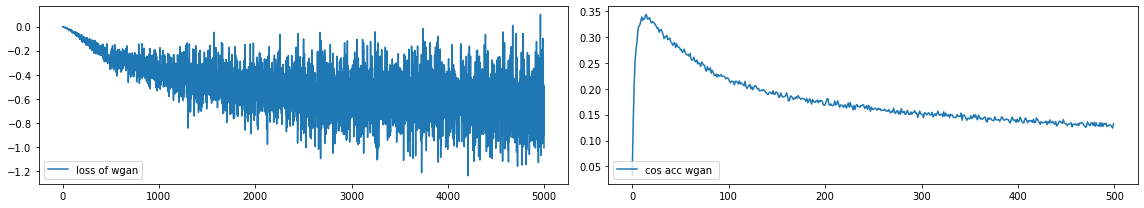

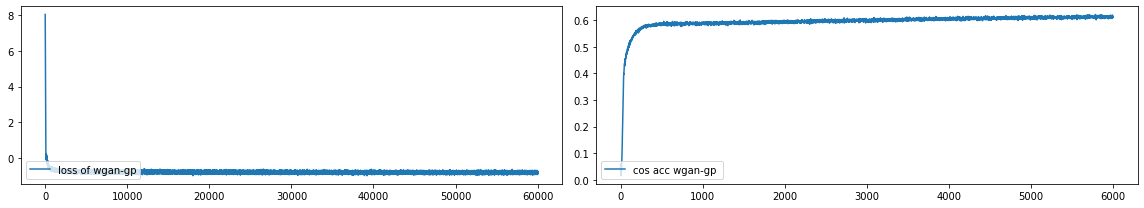

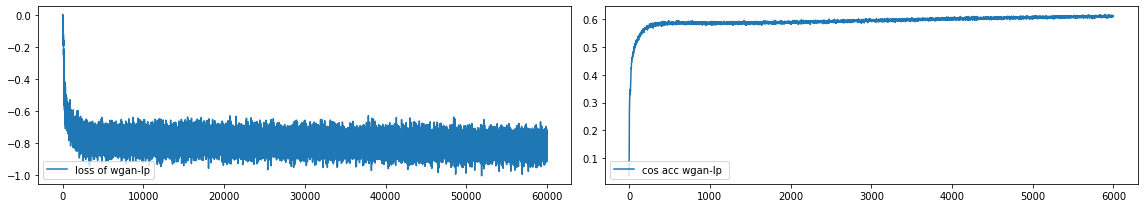

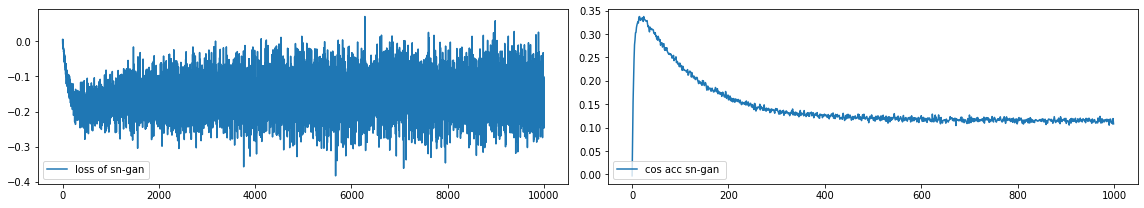

In [9]:
losses = {}
cos_accuracy = {}
times_cos = {}
critic_optimizer = {}
keys = [  'wgan','wgan-gp','wgan-lp','sn-gan']
flags = [ None,'GP','LP',None]
lmbds = {key:val for key, val in zip(keys,[0.,LAMBDA_GP,LAMBDA_LP,0.])}
num_iterations_WGAN = [NUM_ITERATIONS_WGAN, NUM_ITERATIONS_WGAN_GP,NUM_ITERATIONS_WGAN_LP,NUM_ITERATIONS_SN_GAN]
num_iterations_WGAN = {key: num_it for key, num_it in zip(keys,num_iterations_WGAN)}

critic_optimizer = {key:torch.optim.Adam(method[key].parameters(),lr = LR,betas=(0, 0.9)) for key in keys}

for key,flag in zip(keys,flags):
    
    method[key] = method[key].cuda()
    
    losses[key],cos_accuracy[key],times_cos[key]=train_WGAN( 
    critic=method[key], 
    critic_optimizer=critic_optimizer[key],
    sampler_q=benchmark.output_sampler,
    sampler_p=benchmark.input_sampler,
    benchmark=benchmark,
    batch_size=BATCH_SIZE, 
    n_iterations=num_iterations_WGAN[key] ,
    flag_penalty=flag,
    lmbd=lmbds[key]
)
    # take WGAN  on CPU
    method[key]=method[key].cpu()
    del critic_optimizer[key]
    gc.collect(); torch.cuda.empty_cache()
    fig,ax = plt.subplots(1, 2, figsize=(16,3))
    ax[0].plot(losses[key],label='loss of {}'.format(key))
    ax[1].plot(cos_accuracy[key],label='cos acc {} '.format(key))
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    fig.tight_layout()

In [10]:
if DIM == 2:
    folder  = "../checkpoints/nd/dim_{}/width_{}".format(DIM , WIDTH)
    
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    for key in ['wgan','wgan-gp','wgan-lp','sn-gan']:
        path  = os.path.join(folder ,"method_{}.pt".format(key))
        torch.save(method[key].cpu().state_dict(),path)

## 2. CoWGAN : WGAN without GP

In [11]:
method['cowgan']  = Critic(HIDDEN_DIMS,"COWGAN",None, None)
critic_optimizer['cowgan'] = torch.optim.Adam(method['cowgan'].parameters(),lr=LR,betas=(0, 0.9))

In [12]:
method['cowgan'] = method['cowgan'].cuda()
losses_cowgan, cos_accuracy['cowgan'], times_cos['cowgan']=train_CoWGAN(method['cowgan'], critic_optimizer['cowgan'], 
                  benchmark.output_sampler, benchmark.input_sampler,benchmark,BATCH_SIZE, 
                 NUM_ITERATIONS_CoWGAN )

method['cowgan'] = method['cowgan'].cpu()
del critic_optimizer['cowgan']
gc.collect(); torch.cuda.empty_cache()

100%|██████████| 25000/25000 [04:10<00:00, 99.75it/s] 


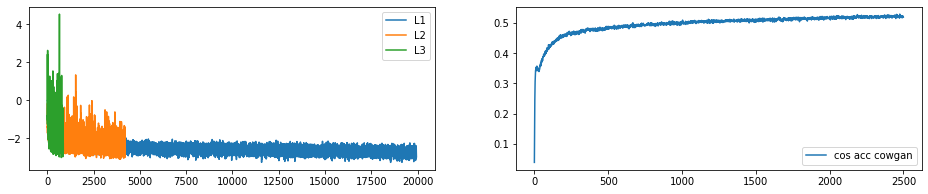

In [13]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(losses_cowgan['L1'],label = 'L1')
ax[0].plot(losses_cowgan['L2'],label = 'L2')
ax[0].plot(losses_cowgan['L3'], label = 'L3')
ax[1].plot(cos_accuracy['cowgan'], label = 'cos acc cowgan')
ax[0].legend()
ax[1].legend();

## 3. LSOT

In [14]:
method['lsot-f'] = Critic(HIDDEN_DIMS,"LSOT",None,None)
method['lsot-g'] = Critic(HIDDEN_DIMS,"LSOT",None, None)
critic_g_optimizer = torch.optim.Adam(method['lsot-g'].parameters(),lr=LR)
critic_f_optimizer = torch.optim.Adam(method['lsot-f'].parameters(),lr=LR)

In [15]:
method['lsot-f'] = method['lsot-f'].cuda()
method['lsot-g'] = method['lsot-g'].cuda()

losses_lsot, cos_accuracy['lsot'],times_cos['lsot'] = train_LSOT(method['lsot-f'],method['lsot-g'],critic_f_optimizer,critic_g_optimizer,
                    benchmark.output_sampler,benchmark.input_sampler,benchmark,
                    BATCH_SIZE,NUM_ITERATIONS_LSOT,  
                    EPSILON_LSOT)

method['lsot-f'] = method['lsot-f'].cpu()
method['lsot-g'] = method['lsot-g'].cpu()
del critic_g_optimizer , critic_f_optimizer
gc.collect(); torch.cuda.empty_cache()

100%|██████████| 10000/10000 [01:46<00:00, 94.27it/s]


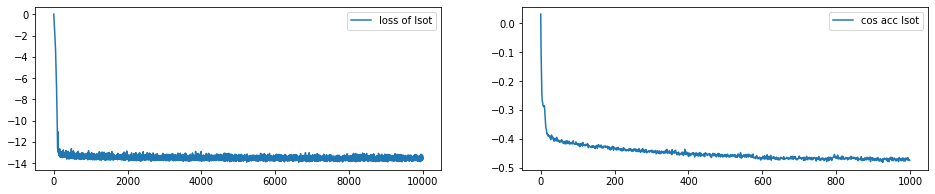

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(losses_lsot,label = 'loss of lsot')
ax[1].plot(cos_accuracy['lsot'], label = 'cos acc lsot')
ax[0].legend()
ax[1].legend();

## 4. 3P-WGAN

In [17]:
mover = Critic(HIDDEN_DIMS_MOVER,"3P-WGAN",None,None )
method['3p-wgan'] = Critic(HIDDEN_DIMS,"3P-WGAN",None,None)
critic_optimizer['3p-wgan']    =  torch.optim.Adam(method['3p-wgan'].parameters(), lr=LR,betas=(0.,0.9))
optimizer_mover      =  torch.optim.Adam(mover.parameters(), lr=LR, betas=(0.,0.9))

In [18]:
mover = mover.cuda()
method['3p-wgan']  = method['3p-wgan'].cuda()

losses_3p, cos_accuracy['3p-wgan'],times_cos['3p-wgan'] = train_3PWGAN(method['3p-wgan'],
              mover,
              critic_optimizer['3p-wgan'],
              optimizer_mover,
              benchmark.output_sampler,
              benchmark.input_sampler,
              benchmark,
              BATCH_SIZE,
              NUM_ITERATIONS_3P_WGAN,
              MOVER_STEPS,
              reverse_flag=False)

method['3p-wgan'] = method['3p-wgan'].cpu()
mover = mover.cpu()
del critic_optimizer['3p-wgan'],optimizer_mover 
gc.collect(); torch.cuda.empty_cache()

100%|██████████| 20000/20000 [22:55<00:00, 14.54it/s]


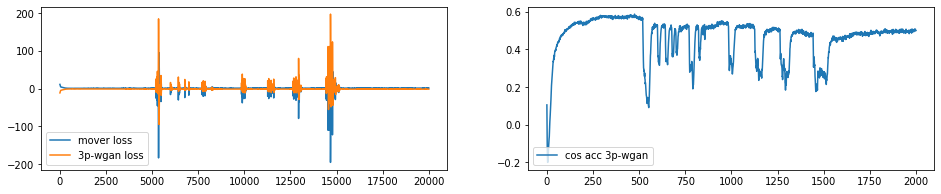

In [19]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(losses_3p['mover'],label = 'mover loss')
ax[0].plot(losses_3p['critic'],label = '3p-wgan loss')
ax[1].plot(cos_accuracy['3p-wgan'],label = 'cos acc 3p-wgan')
ax[0].legend(loc = 'lower left')
ax[1].legend(loc = 'lower left');

## 5. 3P-WGAN_REV

In [20]:
mover_rev = Critic(HIDDEN_DIMS_MOVER,"3P-WGAN",None,None )
method['3p-wgan_rev'] = Critic(HIDDEN_DIMS,"3P-WGAN",None,None)
critic_optimizer['3p-wgan_rev']     =  torch.optim.Adam(method['3p-wgan_rev'].parameters(), lr=LR, betas=(0.,0.9))
optimizer_mover_rev     =  torch.optim.Adam(mover_rev.parameters(), lr=LR, betas=(0.,0.9))

In [21]:
mover_rev = mover_rev.cuda()
method['3p-wgan_rev']  = method['3p-wgan_rev'].cuda()


losses_3p_r,cos_accuracy['3p-wgan_rev'],times_cos['3p-wgan_rev'] = train_3PWGAN(method['3p-wgan_rev'],
              mover_rev,
             critic_optimizer['3p-wgan_rev'],
              optimizer_mover_rev,
              benchmark.output_sampler,
              benchmark.input_sampler,
              benchmark,
              BATCH_SIZE,
              NUM_ITERATIONS_MMR,
              MOVER_STEPS,
              reverse_flag=True,)

method['3p-wgan_rev'] = method['3p-wgan_rev'].cpu()
mover_rev = mover_rev.cpu()
del critic_optimizer['3p-wgan_rev'] , optimizer_mover_rev 
gc.collect(); torch.cuda.empty_cache()

100%|██████████| 20000/20000 [22:41<00:00, 14.69it/s]


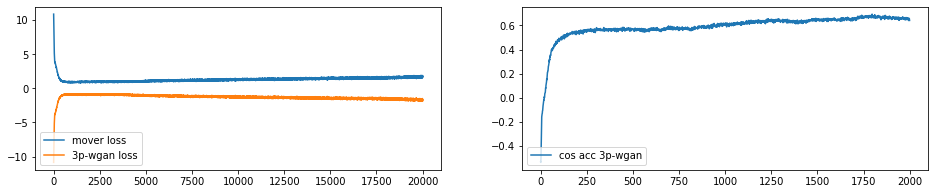

In [22]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(losses_3p_r['mover'],label='mover loss')
ax[0].plot(losses_3p_r['critic'],label='3p-wgan loss')
ax[1].plot(cos_accuracy['3p-wgan_rev'],label = 'cos acc 3p-wgan')
ax[0].legend(loc = 'lower left')
ax[1].legend(loc = 'lower left');

## 7. SORT-OUT

In [23]:
method['sort-out'] = Critic_sort(HIDDEN_DIMS,NUM_UNITS)
critic_optimizer['sort-out'] = torch.optim.Adam(method['sort-out'].parameters(),lr=LR)

In [24]:
method['sort-out'] = method['sort-out'].cuda()


losses_so,cos_accuracy['sort-out'], times_cos['sort-out'] =  train_WGAN( 
    method['sort-out'], 
    critic_optimizer['sort-out'] ,
    sampler_q=benchmark.output_sampler,
    sampler_p=benchmark.input_sampler,
    benchmark=benchmark,
    batch_size=BATCH_SIZE,
    n_iterations=NUM_ITERATIONS_SORT_OUT,
    flag_penalty=None,
    lmbd = 0.)

method['sort-out'] = method['sort-out'].cpu()
del critic_optimizer['sort-out'] 
gc.collect(); torch.cuda.empty_cache()

100%|██████████| 25000/25000 [09:01<00:00, 46.18it/s]


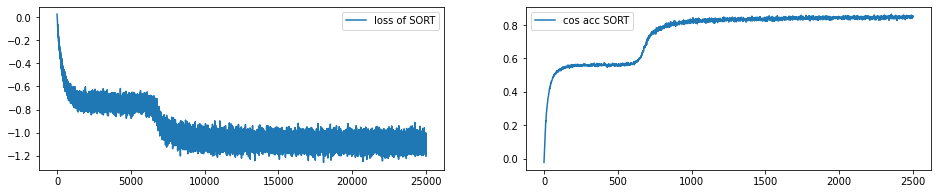

In [25]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(losses_so,label = 'loss of SORT')
ax[1].plot(cos_accuracy['sort-out'], label = 'cos acc SORT')
ax[0].legend()
ax[1].legend();

## 8. WGAN-QP

In [26]:
method['wgan-qp'] =  Critic(HIDDEN_DIMS,"WG",None,None )
critic_optimizer['wgan-qp'] = torch.optim.Adam(method['wgan-qp'].parameters(),lr=LR)

In [27]:
method['wgan-qp'] = method['wgan-qp'].cuda()

loss_qp,cos_accuracy['wgan-qp'],times_cos['wgan-qp'] = train_WGAN_qp(method['wgan-qp'], critic_optimizer['wgan-qp'],  benchmark.output_sampler ,
                     benchmark.input_sampler,benchmark,  BATCH_SIZE,
                  NUM_ITERATIONS_WGAN_QP )

method['wgan-qp'] = method['wgan-qp'].cpu()
del critic_optimizer['wgan-qp'] 
gc.collect(); torch.cuda.empty_cache()

100%|██████████| 25000/25000 [03:34<00:00, 116.79it/s]


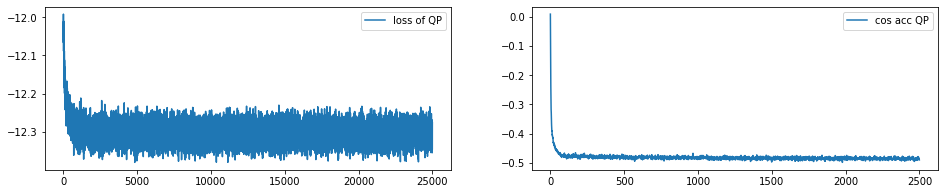

In [28]:
fig,ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(loss_qp,label='loss of QP')
ax[1].plot(cos_accuracy['wgan-qp'], label='cos acc QP')
ax[0].legend()
ax[1].legend();

In [29]:
if DIM == 2:
    folder  = "../checkpoints/nd/dim_{}/width_{}".format(DIM , WIDTH)
    
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    for key in ['cowgan','lsot-f','3p-wgan','3p-wgan_rev','sort-out','wgan-qp']:
        path  = os.path.join(folder ,"method_{}.pt".format(key))
        torch.save(method[key].cpu().state_dict(),path)

## 9. Metrics

In [30]:
keys = ['wgan','wgan-gp','wgan-lp','sn-gan','cowgan','sort-out','3p-wgan','3p-wgan_rev','lsot-f','wgan-qp']
q_samples = benchmark.output_sampler.sample(BATCH_SIZE)
for key in keys:
    method[key] = method[key].cuda()
    q_samples.requires_grad = True
    print(key,(torch.autograd.grad(method[key](q_samples),q_samples,grad_outputs = torch.ones(q_samples.shape[0],1,
                                                        device = q_samples.device))[0].norm(dim=-1) <= 1).all().item())

wgan False
wgan-gp False
wgan-lp False
sn-gan True
cowgan False
sort-out True
3p-wgan False
3p-wgan_rev False
lsot-f True
wgan-qp True


In [31]:
cost = {}
cost['true'] = calculate_unbiased_wasserstein(benchmark,METRIC_SIZE)
 

for key in  ['wgan','wgan-gp','wgan-lp','sn-gan','3p-wgan','3p-wgan_rev','sort-out','lsot-f','wgan-qp','cowgan' ]:
    method[key] = method[key].cuda()
    cost[key] = calculate_kantorovitch_wasserstein( method[key] , key,
                                                       benchmark, METRIC_SIZE  ) 
    method[key] = method[key].cpu()

cost['dot'] = DOT_metrics(benchmark, METRIC_SIZE)[0] 

In [32]:
l2 = {}
 
for key in ['wgan','wgan-gp','wgan-lp','sn-gan','lsot-f','3p-wgan','sort-out','wgan-qp','cowgan']:
    if key in method.keys():
        method[key] = method[key].cuda()
        l2[key] = L2_metrics(method[key],None,benchmark, METRIC_SIZE,
                         flag_rev=False ) 
        method[key] = method[key].cpu()
        
mover_rev = mover_rev.cuda()
l2['3p-wgan_rev'] = L2_metrics(None,mover_rev ,benchmark, METRIC_SIZE,
                               flag_rev=True) 
mover_rev = mover_rev.cpu()

l2['dot'] = DOT_metrics(benchmark, METRIC_SIZE)[1] 
l2['true'] = 0.

In [33]:
cos = {}
 
for key in ['wgan','wgan-gp','wgan-lp','sn-gan','lsot-f','3p-wgan','sort-out','wgan-qp','cowgan']:
    if key in method.keys():
        method[key] = method[key].cuda()
        cos[key] = cosine_metrics(method[key]  ,None,benchmark, METRIC_SIZE,flag_rev=False ) 
        method[key] = method[key].cpu()
 
        
mover_rev = mover_rev.cuda()
cos['3p-wgan_rev'] = cosine_metrics(None , mover_rev  ,benchmark, METRIC_SIZE,flag_rev=True
                                    ) 
mover_rev = mover_rev.cpu()


cos['dot'] = DOT_metrics(benchmark, METRIC_SIZE)[2] 
cos['true'] = 1.0

In [34]:
results = {"cos" : cos , "l2" : l2, "cost" : cost}
results = pd.DataFrame(results)
results

,cos,l2,cost
wgan,0.129848,12.947327,0.665855
wgan-gp,0.614316,0.807005,0.758789
wgan-lp,0.607592,0.807323,0.878839
sn-gan,0.115130,1.689884,0.173288
lsot-f,-0.469803,1.882543,-0.363101
3p-wgan,0.503532,2.490233,1.186960
sort-out,0.848078,0.287601,1.055681
wgan-qp,-0.484674,1.783343,-0.326942
cowgan,0.519589,13.874998,3.056499
3p-wgan_rev,0.660333,0.690597,2.089680


In [35]:
path = "../metrics/metrics_nd/dim_{}/width_{}/".format(DIM,WIDTH)
if not os.path.exists(path):
    os.makedirs(path)
results.to_csv(os.path.join(path,"metrics_deg_{}_seed_{}.csv".format(DEG,SEED_WGAN)))